<a href="https://colab.research.google.com/github/jsansao/dlvc/blob/main/Licao20_IdentificacaoFacial_FineTuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lição 20 - Identificação facial com fine tuning do VGGFace2




## Download do dataset

In [ ]:
!wget https://github.com/jsansao/fame-dataset/archive/refs/heads/main.zip

--2021-11-27 19:18:35--  https://github.com/jsansao/fame-dataset/archive/refs/heads/main.zip
Resolving github.com (github.com)... 52.69.186.44
Connecting to github.com (github.com)|52.69.186.44|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/jsansao/fame-dataset/zip/refs/heads/main [following]
--2021-11-27 19:18:36--  https://codeload.github.com/jsansao/fame-dataset/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 52.193.111.178
Connecting to codeload.github.com (codeload.github.com)|52.193.111.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [             <=>    ]  47.24M  14.4MB/s    in 3.3s    

2021-11-27 19:18:40 (14.4 MB/s) - ‘main.zip’ saved [49530242]



In [ ]:
!unzip main.zip

Archive:  main.zip
e76125873a9351f49ba1f84baf8e2ff90f3731ab
   creating: fame-dataset-main/
   creating: fame-dataset-main/train/
   creating: fame-dataset-main/train/AlPacino/
  inflating: fame-dataset-main/train/AlPacino/1.al_pacino.jpg  
  inflating: fame-dataset-main/train/AlPacino/11.29373_0d16849303cb824.jpg  
  inflating: fame-dataset-main/train/AlPacino/12.210px-al_pacino_roma_film_fest_cropped.jpg  
  inflating: fame-dataset-main/train/AlPacino/13.image-w856.jpg  
  inflating: fame-dataset-main/train/AlPacino/14.os-80-anos-de-al-pacino0298839100202004251215.jpg  
  inflating: fame-dataset-main/train/AlPacino/15.filmes-com-al-pacino-pdb-117%e2%80%8b.jpg  
  inflating: fame-dataset-main/train/AlPacino/19.al-pacino.jpg  
  inflating: fame-dataset-main/train/AlPacino/2.1337912.jpg  
  inflating: fame-dataset-main/train/AlPacino/23.al_pacino_2016_%2830401544240%29.jpg  
  inflating: fame-dataset-main/train/AlPacino/25.al_pacino.jpg  
 extracting: fame-dataset-main/train/AlPacino/26

## Extração das faces do dataset, geração dos conjuntos de treinamento e validação




In [ ]:
!pip install mtcnn

     |████████████████████████████████| 2.3 MB 4.3 MB/s 


In [ ]:
# face detection for the 5 Celebrity Faces Dataset
from os import listdir
from os.path import isdir
from PIL import Image
from matplotlib import pyplot
from numpy import savez_compressed
from numpy import asarray
import mtcnn

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	image = Image.open(filename)
	# convert to RGB, if needed
	image = image.convert('RGB')
	# convert to array
	pixels = asarray(image)
	# create the detector, using default weights
	detector = mtcnn.MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	# bug fix
	x1, y1 = abs(x1), abs(y1)
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load images and extract faces for all images in a directory
def load_faces(directory):
	faces = list()
	# enumerate files
	for filename in listdir(directory):
		# path
		path = directory + filename
		# get face
		face = extract_face(path, (224,224))
		# store
		faces.append(face)
	return faces

# load a dataset that contains one subdir for each class that in turn contains images
def load_dataset(directory):
	X, y = list(), list()
	# enumerate folders, on per class
	for subdir in listdir(directory):
		# path
		path = directory + subdir + '/'
		# skip any files that might be in the dir
		if not isdir(path):
			continue
		# load all faces in the subdirectory
		faces = load_faces(path)
		# create labels
		labels = [subdir for _ in range(len(faces))]
		# summarize progress
		print('>loaded %d examples for class: %s' % (len(faces), subdir))
		# store
		X.extend(faces)
		y.extend(labels)
	return asarray(X), asarray(y)



In [ ]:
# load train dataset
trainX, trainy = load_dataset('/content/fame-dataset-main/train/')
print(trainX.shape, trainy.shape)
# load test dataset
testX, testy = load_dataset('/content/fame-dataset-main/val/')
# save arrays to one file in compressed format
savez_compressed('fame-faces-dataset.npz', trainX, trainy, testX, testy)

>loaded 15 examples for class: TomHanks
>loaded 15 examples for class: KristenStewart
>loaded 15 examples for class: ClintEastwood
>loaded 15 examples for class: AngelinaJolie
>loaded 15 examples for class: EmilyBlunt
>loaded 15 examples for class: MerylStreep
>loaded 15 examples for class: AlPacino
>loaded 20 examples for class: NicolasCage
(125, 224, 224, 3) (125,)
>loaded 4 examples for class: TomHanks
>loaded 11 examples for class: KristenStewart
>loaded 11 examples for class: ClintEastwood
>loaded 3 examples for class: AngelinaJolie
>loaded 3 examples for class: EmilyBlunt
>loaded 11 examples for class: MerylStreep
>loaded 2 examples for class: AlPacino
>loaded 9 examples for class: NicolasCage


## Codificação dos rótulos

In [ ]:
from sklearn.preprocessing import LabelEncoder
out_encoder = LabelEncoder()
out_encoder.fit(trainy)
trainY = out_encoder.transform(trainy)
testY = out_encoder.transform(testy)




## Instação do VGGFACE

In [ ]:


!pip install git+https://github.com/jsansao/keras-vggface.git
!pip install keras_applications



  Cloning https://github.com/jsansao/keras-vggface.git to /tmp/pip-req-build-ezhh0m66
  Running command git clone -q https://github.com/jsansao/keras-vggface.git /tmp/pip-req-build-ezhh0m66
  Created wheel for keras-vggface: filename=keras_vggface-0.6-py3-none-any.whl size=8315 sha256=7a486ac4af50ef4633dbc28e939f49a875819895b70db676455ecd7651be2369
  Stored in directory: /tmp/pip-ephem-wheel-cache-_wohe37z/wheels/17/1d/de/3357313e72504b373dcd31226714c9477da009000aeb307586
Successfully built keras-vggface
     |████████████████████████████████| 50 kB 2.6 MB/s 


In [ ]:


from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray

import mtcnn
from keras.utils.layer_utils import get_source_inputs

from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

from keras.layers import Flatten, Dense, Input

import tensorflow as tf 

## Carregamento do modelo pré-treinado, sem camadas de saída

In [ ]:
nb_class = 8
hidden_dim = 512



model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
model.trainable = False
last_layer = model.get_layer('avg_pool').output
x = Flatten(name='flatten')(last_layer)
out = Dense(nb_class, activation='softmax', name='classifier')(x)
custom_vgg_model = tf.keras.Model(model.input, out)

custom_vgg_model.summary()

Model: "model_537"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_539 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_539[0][0]']              
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                         

## Treinamento das camadas de saída

In [ ]:

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
custom_vgg_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)


In [ ]:
history = custom_vgg_model.fit( trainX, trainY, validation_data=(testX, testY),   epochs=20)

Epoch 1/20
4/4 [==============================] - 28s 7s/step - loss: 4.4967 - accuracy: 0.1920 - val_loss: 1.4865 - val_accuracy: 0.6111
Epoch 2/20
4/4 [==============================] - 24s 7s/step - loss: 0.7148 - accuracy: 0.7920 - val_loss: 0.2629 - val_accuracy: 0.9074
Epoch 3/20
4/4 [==============================] - 24s 7s/step - loss: 0.1200 - accuracy: 0.9440 - val_loss: 0.1091 - val_accuracy: 0.9444
Epoch 4/20
4/4 [==============================] - 24s 7s/step - loss: 0.0598 - accuracy: 0.9760 - val_loss: 0.0714 - val_accuracy: 0.9815
Epoch 5/20
4/4 [==============================] - 24s 7s/step - loss: 0.0262 - accuracy: 0.9920 - val_loss: 0.0563 - val_accuracy: 0.9815
Epoch 6/20
4/4 [==============================] - 24s 7s/step - loss: 0.0166 - accuracy: 0.9920 - val_loss: 0.0478 - val_accuracy: 0.9815
Epoch 7/20
4/4 [==============================] - 24s 7s/step - loss: 0.0126 - accuracy: 0.9920 - val_loss: 0.0425 - val_accuracy: 0.9815
Epoch 8/20
4/4 [==================

## Fine-tuning 

In [ ]:
model.trainable = True

custom_vgg_model.summary()

Model: "model_537"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_539 (InputLayer)         [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_539[0][0]']              
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                         

In [ ]:
optimizer = Adam(learning_rate=1e-5)
custom_vgg_model.compile(loss="sparse_categorical_crossentropy", metrics=['accuracy'], optimizer=optimizer)


In [ ]:
history = custom_vgg_model.fit( trainX, trainY, validation_data=(testX, testY),   epochs=20)

Epoch 1/20
4/4 [==============================] - 97s 24s/step - loss: 0.0233 - accuracy: 1.0000 - val_loss: 0.0294 - val_accuracy: 0.9815
Epoch 2/20
4/4 [==============================] - 87s 22s/step - loss: 0.0036 - accuracy: 1.0000 - val_loss: 0.0261 - val_accuracy: 1.0000
Epoch 3/20
4/4 [==============================] - 88s 22s/step - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0226 - val_accuracy: 1.0000
Epoch 4/20
4/4 [==============================] - 88s 22s/step - loss: 3.5885e-04 - accuracy: 1.0000 - val_loss: 0.0194 - val_accuracy: 1.0000
Epoch 5/20
4/4 [==============================] - 87s 22s/step - loss: 5.2436e-04 - accuracy: 1.0000 - val_loss: 0.0182 - val_accuracy: 1.0000
Epoch 6/20
4/4 [==============================] - 88s 22s/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.0163 - val_accuracy: 1.0000
Epoch 7/20
4/4 [==============================] - 88s 22s/step - loss: 1.9865e-04 - accuracy: 1.0000 - val_loss: 0.0146 - val_accuracy: 1.0000
Epoch 8/20
4/4 

## Teste do modelo

In [ ]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving 27.tom-hanks-globo-de-ouro-2020-2487874.jpg to 27.tom-hanks-globo-de-ouro-2020-2487874.jpg
Saving 26.1167635.jpg to 26.1167635.jpg
Saving 25.05190618857480.jpg to 25.05190618857480.jpg
Saving 28.tom-hanks-apple.jpg to 28.tom-hanks-apple.jpg
User uploaded file "27.tom-hanks-globo-de-ouro-2020-2487874.jpg" with length 69344 bytes
User uploaded file "26.1167635.jpg" with length 1609989 bytes
User uploaded file "25.05190618857480.jpg" with length 404081 bytes
User uploaded file "28.tom-hanks-apple.jpg" with length 87298 bytes


In [ ]:
import numpy as np


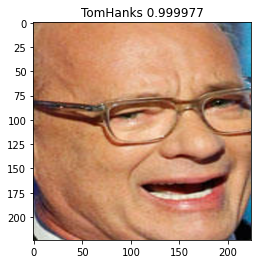

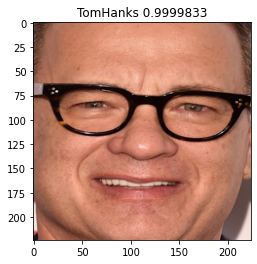

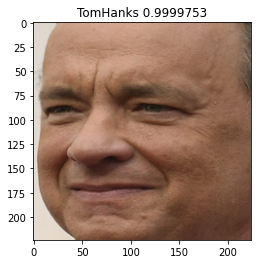

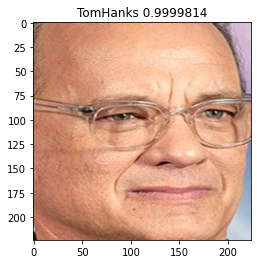

In [ ]:

for fn in uploaded.keys():
  # load the photo and extract the face
  pixels = extract_face(fn)
  pyplot.imshow(pixels)

  # plot the extracted face
  # convert one face into samples
  pixels = pixels.astype('float32')
  samples = expand_dims(pixels, axis=0)
  # prepare the face for the model, e.g. center pixels
  samples = preprocess_input(samples, version=2)

  # perform prediction
  yhat = custom_vgg_model.predict(samples)
  id = out_encoder.classes_[np.argmax(yhat)]
  titulo = id + ' ' + str(np.max(yhat))
  pyplot.title(titulo)
  # show the plot

  pyplot.show()
